1. Daten einlesen und Überprüfung der Struktur

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# 1. Daten einlesen
global_temp = pd.read_csv("GlobalLandTemperaturesByCountry/GlobalLandTemperaturesByCountry.csv")
holidays = pd.read_csv("store-sales-time-series-forecasting/holidays_events.csv")
oil = pd.read_csv("store-sales-time-series-forecasting/oil.csv")
stores = pd.read_csv("store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("store-sales-time-series-forecasting/transactions.csv")
walmart_sales = pd.read_csv("Walmart_Sales_Forecasting/clean_data.csv")

# Überprüfung der Datenstruktur
print(global_temp.head())
print(holidays.head())
print(oil.head())
print(stores.head())
print(transactions.head())
print(walmart_sales.head())

           dt  AverageTemperature  AverageTemperatureUncertainty Country
0  1743-11-01               4.384                          2.294   Åland
1  1743-12-01                 NaN                            NaN   Åland
2  1744-01-01                 NaN                            NaN   Åland
3  1744-02-01                 NaN                            NaN   Åland
4  1744-03-01                 NaN                            NaN   Åland
         date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4 

2. Daten bereinigen und verarbeiten

In [2]:
# Gibt es fehlende Werte?
# Überprüfung auf fehlende Werte in den verschiedenen Dateien
print("Fehlende Werte in global_temp:")
print(global_temp.isnull().sum())

print("Fehlende Werte in holidays_events:")
print(holidays.isnull().sum())

print("Fehlende Werte in oil:")
print(oil.isnull().sum())

print("Fehlende Werte in stores:")
print(stores.isnull().sum())

print("Fehlende Werte in transactions:")
print(transactions.isnull().sum())

print("Fehlende Werte in walmart_sales:")
print(walmart_sales.isnull().sum())

# Entfernen oder Auffüllen?
# Entfernen
global_temp = global_temp.dropna(subset=['AverageTemperature'])

# Auffüllen
transactions = transactions.fillna(0)
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate()
walmart_sales = walmart_sales.fillna(0)

# Datums und Ortinformationen korrekt formatieren
# Global Land Temperatures
global_temp['dt'] = pd.to_datetime(global_temp['dt'])

# Transactions
transactions['date'] = pd.to_datetime(transactions['date'])

# Ölpreise
oil['date'] = pd.to_datetime(oil['date'])

# Walmart Sales
walmart_sales['Date'] = pd.to_datetime(walmart_sales['Date'])

# Überprüfen, ob das Datumsformat korrekt übernommen wurde
print(global_temp['dt'].head())
print(transactions['date'].head())
print(oil['date'].head())
print(walmart_sales['Date'].head())

# Verarbeitung von Feiertagsdaten
# Falls es ein Datumsfeld in holidays_events gibt, konvertiere es in ein Datetime-Format
holidays['date'] = pd.to_datetime(holidays['date'])

Fehlende Werte in global_temp:
dt                                   0
AverageTemperature               32651
AverageTemperatureUncertainty    31912
Country                              0
dtype: int64
Fehlende Werte in holidays_events:
date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64
Fehlende Werte in oil:
date           0
dcoilwtico    43
dtype: int64
Fehlende Werte in stores:
store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64
Fehlende Werte in transactions:
date            0
store_nbr       0
transactions    0
dtype: int64
Fehlende Werte in walmart_sales:
Unnamed: 0      0
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Super_Bowl      0
Labor_Day 

3. Explorative Analyse (EDA) und deren Visualisierungen + Korrelationen

Global Land Temperatures - Beschreibende Statistik:
                                  dt  AverageTemperature  \
count                         544811       544811.000000   
mean   1913-08-08 18:20:24.887162624           17.193354   
min              1743-11-01 00:00:00          -37.658000   
25%              1869-11-01 00:00:00           10.025000   
50%              1919-08-01 00:00:00           20.901000   
75%              1966-10-01 00:00:00           25.814000   
max              2013-09-01 00:00:00           38.842000   
std                              NaN           10.953966   

       AverageTemperatureUncertainty  
count                  544811.000000  
mean                        1.019190  
min                         0.052000  
25%                         0.323000  
50%                         0.571000  
75%                         1.207000  
max                        15.003000  
std                         1.202634  
Transactions (Store Sales) - Beschreibende Statistik:
  

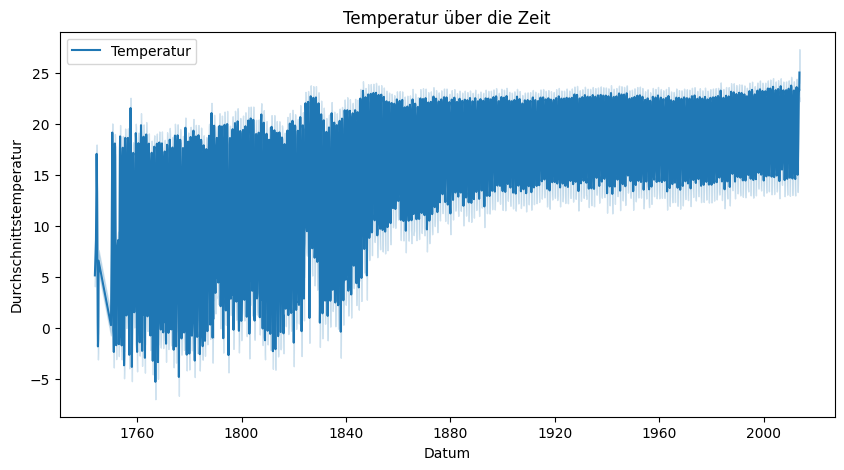

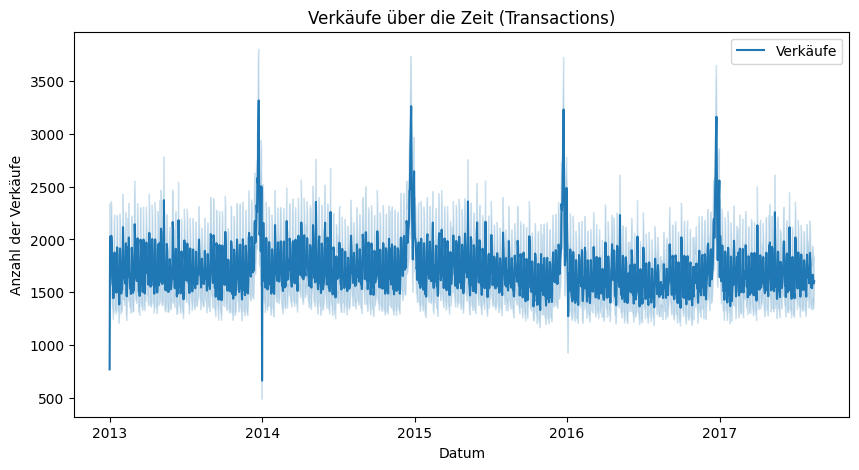

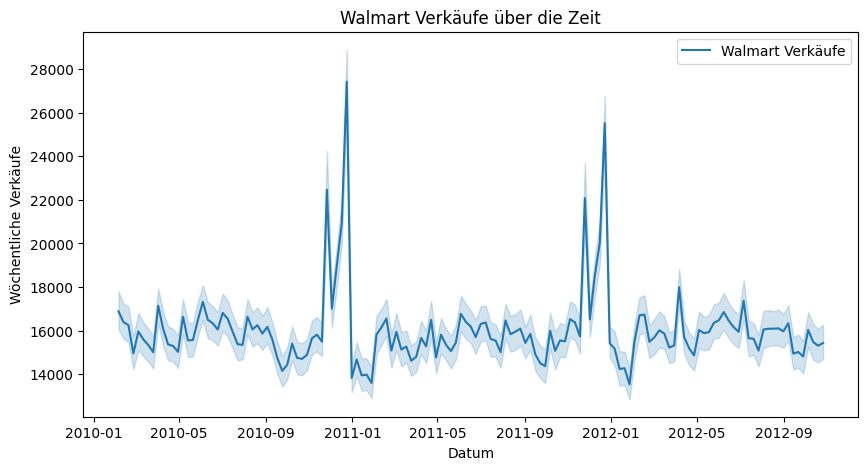

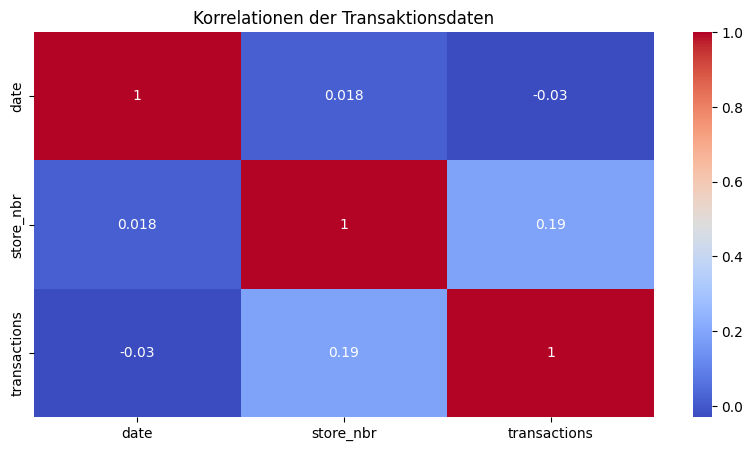

Einzigartige Werte in der Spalte 'Type': ['A' 'B' 'C']
0    1
1    1
2    1
3    1
4    1
Name: Type, dtype: int64


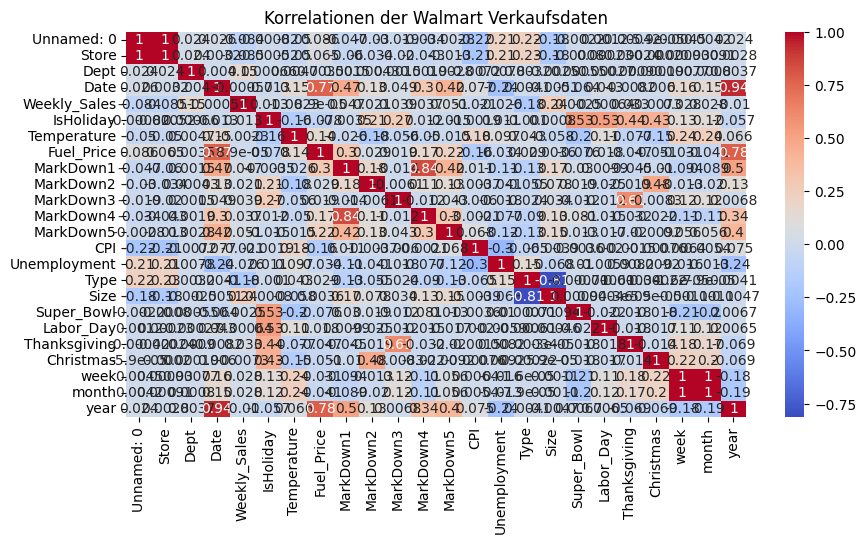

In [3]:
# Beschreibende Analysen
print("Global Land Temperatures - Beschreibende Statistik:")
print(global_temp.describe())

print("Transactions (Store Sales) - Beschreibende Statistik:")
print(transactions.describe())

print("Oil Prices - Beschreibende Statistik:")
print(oil.describe())

print("Walmart Sales - Beschreibende Statistik:")
print(walmart_sales.describe())

# Visualisierungen

# Zeitreihen-Darstellung von Temperatur und Verkaufszahlen
# Plot für Temperaturen
plt.figure(figsize=(10, 5))
sns.lineplot(data=global_temp, x='dt', y='AverageTemperature', label='Temperatur')
plt.title('Temperatur über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Durchschnittstemperatur')
plt.show()

# Plot für Verkäufe (Store Sales)
plt.figure(figsize=(10, 5))
sns.lineplot(data=transactions, x='date', y='transactions', label='Verkäufe')
plt.title('Verkäufe über die Zeit (Transactions)')
plt.xlabel('Datum')
plt.ylabel('Anzahl der Verkäufe')
plt.show()

# Plot für Walmart Verkäufe
plt.figure(figsize=(10, 5))
sns.lineplot(data=walmart_sales, x='Date', y='Weekly_Sales', label='Walmart Verkäufe')
plt.title('Walmart Verkäufe über die Zeit')
plt.xlabel('Datum')
plt.ylabel('Wöchentliche Verkäufe')
plt.show()

# Korrelationen untersuchen

# Korrelationen für Transaktionen
corr_transactions = transactions.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_transactions, annot=True, cmap="coolwarm")
plt.title('Korrelationen der Transaktionsdaten')
plt.show()

# Korrelationen für Walmart

# Einzigartige Werte der Spalte 'Type' auslesen
unique_types = walmart_sales['Type'].unique()
print("Einzigartige Werte in der Spalte 'Type':", unique_types)

# Zuordnung der 'Type'-Werte zu numerischen Werten (dies ist ein Beispiel, du kannst eigene Werte wählen)
type_mapping = {
    'A': 1,
    'B': 2,
    'C': 3
}

# Die Spalte 'Type' mit den numerischen Werten ersetzen
walmart_sales['Type'] = walmart_sales['Type'].map(type_mapping)

# Überprüfen, ob die Umwandlung erfolgreich war
print(walmart_sales['Type'].head())

# Nun kannst du die Korrelationen erneut berechnen
corr_walmart = walmart_sales.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(corr_walmart, annot=True, cmap="coolwarm")
plt.title('Korrelationen der Walmart Verkaufsdaten')
plt.show()

4. Daten kombinieren

In [4]:
# Verknüpfen der Temperaturdaten mit den Transaktionsdaten anhand des Datums
# Da global_temp 'dt' als Datums-Spalte hat und transactions 'date', verwenden wir diese zur Verknüpfung
combined_transactions = pd.merge(transactions, global_temp, left_on='date', right_on='dt', how='inner')

# Nur Daten für die USA herausfiltern
combined_transactions = combined_transactions[combined_transactions['Country'] == 'United States']

# Überprüfen, ob die Verknüpfung erfolgreich war
print(combined_transactions.head())

# Verknüpfen der Temperaturdaten mit Walmart Sales anhand des Datums
# Verwende 'Date' in walmart_sales und 'dt' in global_temp
combined_walmart = pd.merge(walmart_sales, global_temp, left_on='Date', right_on='dt', how='inner')

# Nur Daten für die USA herausfiltern
combined_walmart = combined_walmart[combined_walmart['Country'] == 'United States']

# Überprüfen, ob die Verknüpfung erfolgreich war
print(combined_walmart.head())

# Unnötige Spalten wie doppelte Datumsangaben entfernen
combined_transactions.drop(columns=['dt', 'Country'], inplace=True)
combined_walmart.drop(columns=['dt', 'Country'], inplace=True)

           date  store_nbr  transactions         dt  AverageTemperature  \
232  2013-01-01         25           770 2013-01-01              -2.155   
474  2013-02-01          1          1806 2013-02-01              -1.216   
716  2013-02-01          2          1977 2013-02-01              -1.216   
958  2013-02-01          3          3230 2013-02-01              -1.216   
1200 2013-02-01          4          1520 2013-02-01              -1.216   

      AverageTemperatureUncertainty        Country  
232                           0.185  United States  
474                           0.216  United States  
716                           0.216  United States  
958                           0.216  United States  
1200                          0.216  United States  
      Unnamed: 0  Store  Dept       Date  Weekly_Sales  IsHoliday  \
232         2433      1     1 2010-10-01      20094.19      False   
474         2434      1     2 2010-10-01      45829.02      False   
716         2435      1 

5. Analyse des Einflusses von Wetter auf die Preise

transactions          float64
AverageTemperature    float64
dtype: object
   transactions  AverageTemperature
0    770.000000              -2.155
1   1702.217391              -1.216
2   1728.782609               2.289
3   1775.608696               6.970
4   1968.434783              14.073
Empty DataFrame
Columns: [year_month, transactions, AverageTemperature]
Index: []
  year_month  transactions  AverageTemperature
0    2013-01    770.000000              -2.155
1    2013-02   1702.217391              -1.216
year_month            0
transactions          0
AverageTemperature    0
dtype: int64


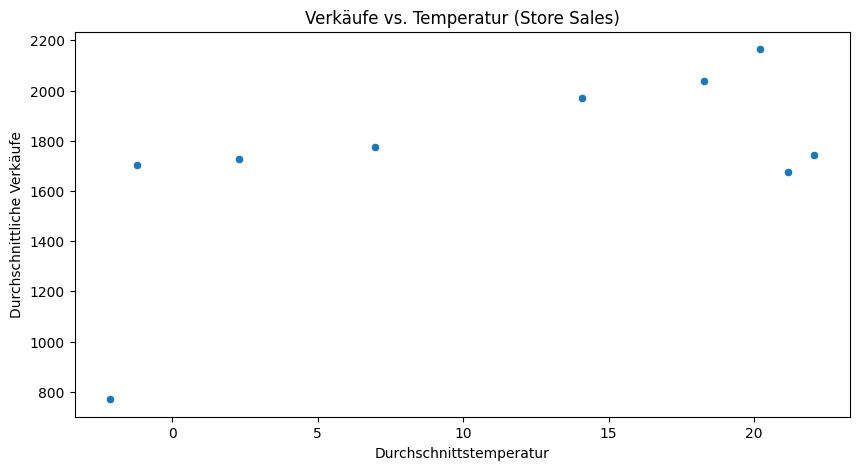

Steigung (Einfluss der Temperatur auf Verkäufe): [24.60210712]
Intercept: 1451.660745747453
Weekly_Sales          float64
AverageTemperature    float64
dtype: object
   Weekly_Sales  AverageTemperature
0  14431.171032              10.913
1  14802.393774               8.582
2  16311.509698              22.722
3  16478.487007              19.954
Empty DataFrame
Columns: [year_month, Weekly_Sales, AverageTemperature]
Index: []
Empty DataFrame
Columns: [year_month, Weekly_Sales, AverageTemperature]
Index: []
year_month            0
Weekly_Sales          0
AverageTemperature    0
dtype: int64


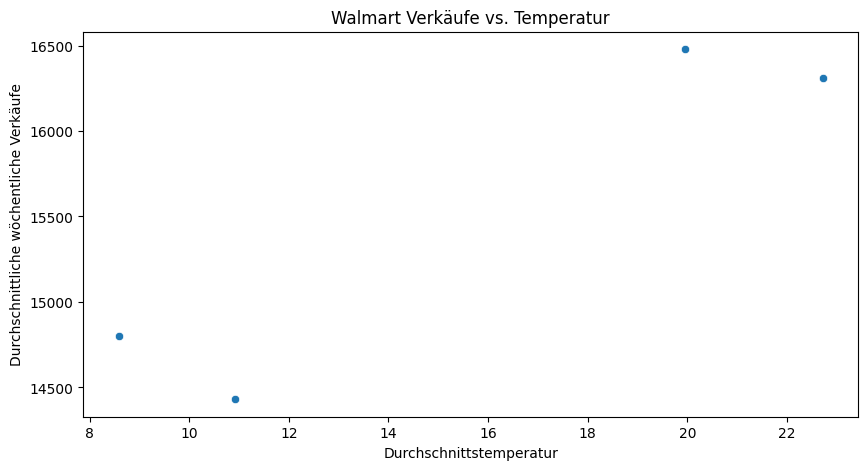

Steigung (Einfluss der Temperatur auf Walmart Verkäufe): [141.57871965]
Intercept: 13305.367732815026


In [5]:
# Erstellung einer neuen Spalte für Jahr und Monat
combined_transactions['year_month'] = combined_transactions['date'].dt.to_period('M')

# Berechnen der monatlichen Durchschnittswerte für Verkäufe und Temperatur
monthly_data_transactions = combined_transactions.groupby('year_month').agg({
    'transactions': 'mean',
    'AverageTemperature': 'mean'
}).reset_index()

# Überprüfen auf nicht-numerische Werte
print(monthly_data_transactions[['transactions', 'AverageTemperature']].dtypes)
print(monthly_data_transactions[['transactions', 'AverageTemperature']].head())

# Suche nach nicht-numerischen Werten
print(monthly_data_transactions[~monthly_data_transactions['transactions'].apply(lambda x: str(x).replace('.', '', 1).isdigit())])
print(monthly_data_transactions[~monthly_data_transactions['AverageTemperature'].apply(lambda x: str(x).replace('.', '', 1).isdigit())])

# Konvertiere die Spalten in numerische Werte
monthly_data_transactions['transactions'] = pd.to_numeric(monthly_data_transactions['transactions'], errors='coerce')
monthly_data_transactions['AverageTemperature'] = pd.to_numeric(monthly_data_transactions['AverageTemperature'], errors='coerce')

# Überprüfen auf NaN-Werte nach der Konvertierung
print(monthly_data_transactions.isnull().sum())

# Entferne Zeilen mit NaN-Werten
monthly_data_transactions.dropna(subset=['transactions', 'AverageTemperature'], inplace=True)

# Scatter Plot zwischen Temperatur und Verkäufen
plt.figure(figsize=(10, 5))
sns.scatterplot(data=monthly_data_transactions, x='AverageTemperature', y='transactions')
plt.title('Verkäufe vs. Temperatur (Store Sales)')
plt.xlabel('Durchschnittstemperatur')
plt.ylabel('Durchschnittliche Verkäufe')
plt.show()

# Lineare Regression (Einfluss der Temperatur auf die Verkäufe)
X_transactions = monthly_data_transactions[['AverageTemperature']]
y_transactions = monthly_data_transactions['transactions']

model_transactions = LinearRegression()
model_transactions.fit(X_transactions, y_transactions)

print("Steigung (Einfluss der Temperatur auf Verkäufe):", model_transactions.coef_)
print("Intercept:", model_transactions.intercept_)

# Erstellung einer neuen Spalte für Jahr und Monat in den Walmart-Daten
combined_walmart['year_month'] = combined_walmart['Date'].dt.to_period('M')

# Berechnen der monatlichen Durchschnittswerte für Verkäufe und Temperatur
monthly_data_walmart = combined_walmart.groupby('year_month').agg({
    'Weekly_Sales': 'mean',
    'AverageTemperature': 'mean'
}).reset_index()

# Überprüfen auf nicht-numerische Werte
print(monthly_data_walmart[['Weekly_Sales', 'AverageTemperature']].dtypes)
print(monthly_data_walmart[['Weekly_Sales', 'AverageTemperature']].head())

# Suche nach nicht-numerischen Werten
print(monthly_data_walmart[~monthly_data_walmart['Weekly_Sales'].apply(lambda x: str(x).replace('.', '', 1).isdigit())])
print(monthly_data_walmart[~monthly_data_walmart['AverageTemperature'].apply(lambda x: str(x).replace('.', '', 1).isdigit())])

# Konvertiere die Spalten in numerische Werte
monthly_data_walmart['Weekly_Sales'] = pd.to_numeric(monthly_data_walmart['Weekly_Sales'], errors='coerce')
monthly_data_walmart['AverageTemperature'] = pd.to_numeric(monthly_data_walmart['AverageTemperature'], errors='coerce')

# Überprüfen auf NaN-Werte nach der Konvertierung
print(monthly_data_walmart.isnull().sum())

# Entferne Zeilen mit NaN-Werten
monthly_data_walmart.dropna(subset=['Weekly_Sales', 'AverageTemperature'], inplace=True)

# Scatter Plot zwischen Temperatur und Walmart Verkäufen
plt.figure(figsize=(10, 5))
sns.scatterplot(data=monthly_data_walmart, x='AverageTemperature', y='Weekly_Sales')
plt.title('Walmart Verkäufe vs. Temperatur')
plt.xlabel('Durchschnittstemperatur')
plt.ylabel('Durchschnittliche wöchentliche Verkäufe')
plt.show()

# Lineare Regression (Einfluss der Temperatur auf Walmart Verkäufe)
X_walmart = monthly_data_walmart[['AverageTemperature']]
y_walmart = monthly_data_walmart['Weekly_Sales']

model_walmart = LinearRegression()
model_walmart.fit(X_walmart, y_walmart)

print("Steigung (Einfluss der Temperatur auf Walmart Verkäufe):", model_walmart.coef_)
print("Intercept:", model_walmart.intercept_)

6. Random-Forest und andere

Vorhersagen:  [14844.84553841 15822.62164502]
Mean Squared Error: 464.73730490179327
R^2 Score: 0.6924762115460531
Vorhergesagte Verkäufe für zukünftige Temperaturen:  [15822.62164502 15822.62164502 15822.62164502 15822.62164502]


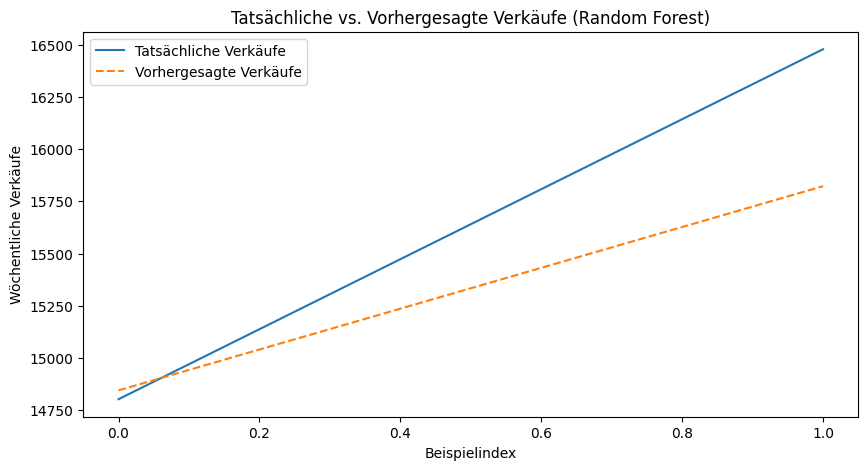

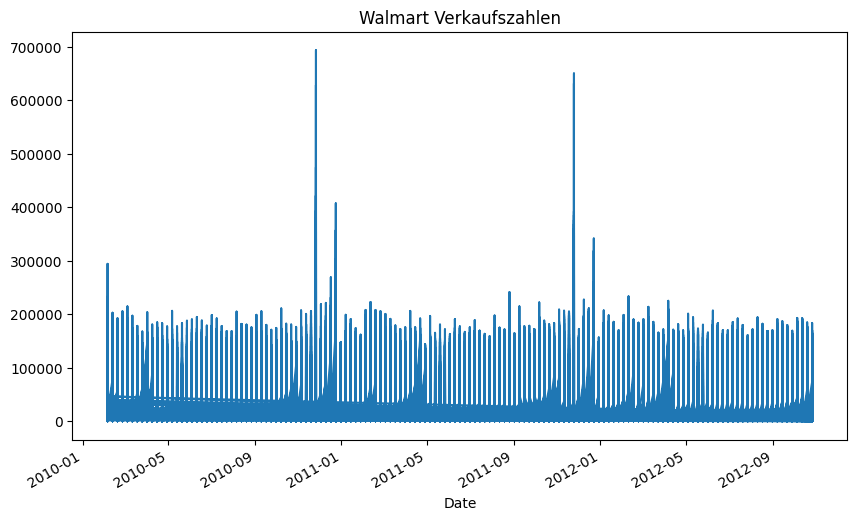

ADF Test Statistic: -9.220688176485151
p-value: 1.783387695155538e-15
Die Zeitreihe ist stationär


c:\Users\kasum\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kasum\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kasum\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\kasum\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not mo

In [ ]:
# Walmart
# Erstellung des Features und des Zielwerts
X_walmart = monthly_data_walmart[['AverageTemperature']]
y_walmart = monthly_data_walmart['Weekly_Sales']

# Aufteilen in Trainings- und Testdaten
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_walmart, y_walmart, test_size=0.45, random_state=9) # Default-Werte: test_size=0.2, random_state=42

# Modell erstellen
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Modell trainieren
rf_model.fit(X_train, y_train)

# Vorhersagen für die Testdaten machen
y_pred = rf_model.predict(X_test)

# Ergebnisse anzeigen
print("Vorhersagen: ", y_pred)

# Modellperformance überprüfen
mse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Forecasting (Walmart)
# Beispiel: Vorhersagen für zukünftige Temperaturen
future_temperatures = pd.DataFrame({'AverageTemperature': [30, 35, 40, 45]})  # Beispielhafte zukünftige Temperaturen

# Vorhersagen für die zukünftigen Temperaturen
future_sales_predictions = rf_model.predict(future_temperatures)

print("Vorhergesagte Verkäufe für zukünftige Temperaturen: ", future_sales_predictions)

# Visualisierung des Forecast
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Tatsächliche Verkäufe')
plt.plot(y_pred, label='Vorhergesagte Verkäufe', linestyle='--')
plt.title('Tatsächliche vs. Vorhergesagte Verkäufe (Random Forest)')
plt.xlabel('Beispielindex')
plt.ylabel('Wöchentliche Verkäufe')
plt.legend()
plt.show()


# SARIMA-Modell
# 1. Daten laden und vorbereiten
walmart_sales = pd.read_csv("Walmart_Sales_Forecasting/clean_data.csv", parse_dates=['Date'], index_col='Date')

# 2. Verkaufsdaten plotten, um das Muster zu sehen
walmart_sales['Weekly_Sales'].plot(figsize=(10,6))
plt.title('Walmart Verkaufszahlen')
plt.show()

# 3. Stationarität testen (Dickey-Fuller-Test)
adf_test = adfuller(walmart_sales['Weekly_Sales'])

print(f'ADF Test Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')
if adf_test[1] < 0.05:
    print("Die Zeitreihe ist stationär")
else:
    print("Die Zeitreihe ist nicht stationär. Du solltest differenzieren (d-Wert anpassen).")

# 4. SARIMA-Modell anpassen
# SARIMA(p, d, q)(P, D, Q, m) 
model = SARIMAX(walmart_sales['Weekly_Sales'],
                order=(1, 1, 1),             # ARIMA-Parameter
                seasonal_order=(1, 1, 1, 52)) # saisonale Parameter (z.B. 52 Wochen für Jahreszyklen)

# 5. Modell fitten
sarima_model = model.fit(disp=False)

# 6. Vorhersagen auf Testdaten machen
walmart_sales['Forecast'] = sarima_model.predict(start=len(walmart_sales) - 52, end=len(walmart_sales), dynamic=True)

# 7. Ergebnisse plotten
plt.figure(figsize=(10, 6))
plt.plot(walmart_sales.index, walmart_sales['Weekly_Sales'], label='Echte Verkaufszahlen')
plt.plot(walmart_sales.index, walmart_sales['Forecast'], label='SARIMA Vorhersage', color='red')
plt.title('SARIMA Vorhersage vs. Echte Verkaufszahlen')
plt.legend()
plt.show()

# 8. Modellbewertung (optional)
sarima_model.summary()
